# Warehouse Optimization (Model Only)

## Initilization

In [12]:
import pandas as pd
import pandas_profiling
import numpy as np
data = pd.read_csv('ML_datafile.csv')
data.reset_index(drop=True, inplace=True)
data = data.drop(['Item No', 'Manufacturer No', 'Product Name', 'Date', 'STOCK TYPE', 'In Stock', 'List No',
                 'UPC Code', 'SaleRate'], axis=1)

In [13]:
# limit to categorical data using df.select_dtypes()
#nominal_data = data.drop(['Price(USD)', 'Cost price', 'Inventory', 'Shipping', 'Profit', 'weight(lb)', 'SaleRateNew'], axis=1)
#ordinal_data = data.drop(nominal_data.columns)
nominal_data = data.select_dtypes(include=[object])
ordinal_data = data.drop(list(nominal_data.columns), axis=1)
nominal_data = nominal_data.replace(np.nan, 'Default', regex=True)

## One-Hot Encoding

In [14]:
from sklearn import preprocessing
nominal_data_2 = nominal_data
# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()
# 2. FIT
enc.fit(nominal_data_2)
# 3. Transform
onehotlabels = enc.transform(nominal_data_2).toarray()
print(onehotlabels.shape)

(4200, 458)


In [15]:
encoded_data = pd.concat([ordinal_data, pd.DataFrame(onehotlabels)], axis=1)

In [16]:
encoded_data.columns


Index([ 'Price(USD)',  'Cost price',   'Inventory',    'Shipping',
            'Profit',  'weight(lb)', 'SaleRateNew',     'Blowout',
                   0,             1,
       ...
                 448,           449,           450,           451,
                 452,           453,           454,           455,
                 456,           457],
      dtype='object', length=466)

## Data Split

In [17]:
X = encoded_data.drop('SaleRateNew', axis=1)
Y = encoded_data['SaleRateNew']

## Tunning

In [18]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2)

In [22]:
#Regression	 	 
#‘explained_variance’	metrics.explained_variance_score	 
#‘max_error’	metrics.max_error	 
#‘neg_mean_absolute_error’	metrics.mean_absolute_error	 
#‘neg_mean_squared_error’	metrics.mean_squared_error	 
#‘neg_mean_squared_log_error’	metrics.mean_squared_log_error	 
#‘neg_median_absolute_error’	metrics.median_absolute_error	 
#‘r2’	metrics.r2_score

from matplotlib import pyplot as plt
%matplotlib inline

def test(models, X, Y, iterations = 10):
    results = {}
    for i in models:
        print("\nRunning ", i)
        r2_train = []
        r2_test = []
        mae_train = []
        mae_test = []
        for j in range(iterations):
            print(j, end='')
            r2_test.append(metrics.r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(metrics.r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
            mae_test.append(metrics.mean_absolute_error(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            mae_train.append(metrics.mean_absolute_error(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        plt.figure()
        plt.plot(r2_test, label='r2_test')
        plt.xlabel('Iterations') 
        plt.ylabel('Score')
        plt.title("r2_test")
        plt.figure()
        plt.plot(r2_train, label='r2_train')
        plt.xlabel('Iterations') 
        plt.ylabel('Score') 
        plt.title("r2_train")
        results[i] = [np.mean(r2_train), np.mean(r2_test), np.mean(mae_train), np.mean(mae_test)]
    return pd.DataFrame(results), models

In [23]:
models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(),
         'Ridge': linear_model.Ridge(),
         'Ada': AdaBoostRegressor(),
         'GBM': GradientBoostingRegressor()}


Running  OLS
0123456789
Running  Lasso
0123456789
Running  Ridge
0123456789
Running  Ada
0123456789
Running  GBM
0123456789Wall time: 5min 52s


,OLS,Lasso,Ridge,Ada,GBM
0,0.758538,0.704113,0.754924,0.936178,0.993459
1,0.694711,0.704658,0.713377,0.934155,0.987321
2,0.374011,0.426297,0.376117,0.227995,0.053916
3,0.412584,0.423740,0.407406,0.243557,0.065036


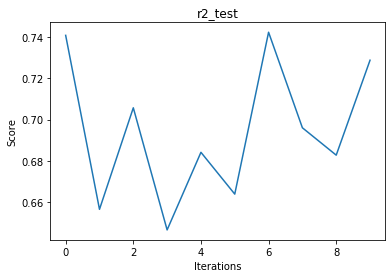

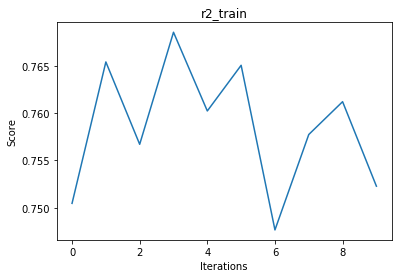

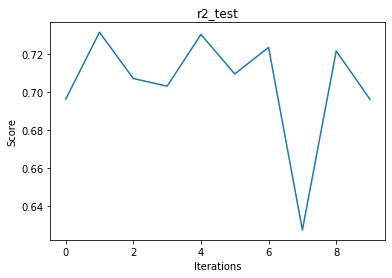

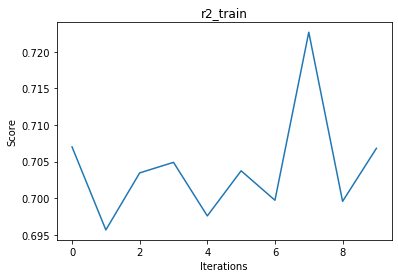

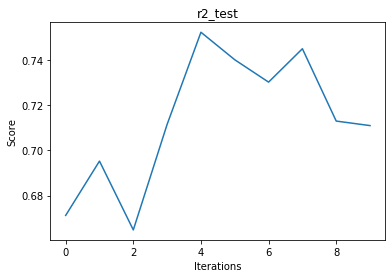

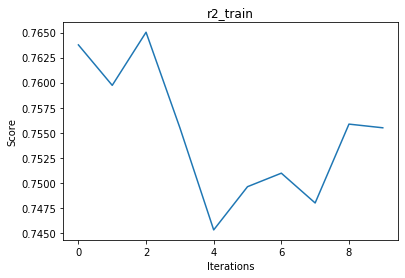

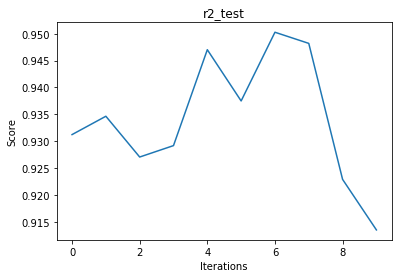

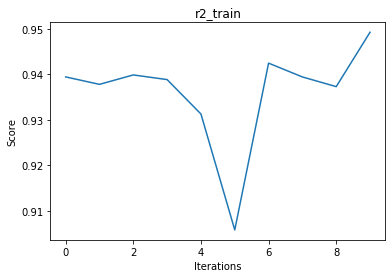

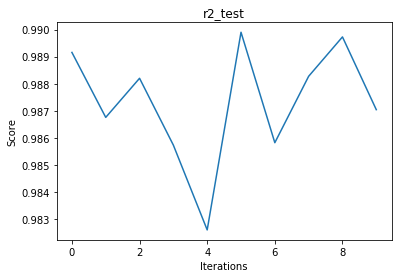

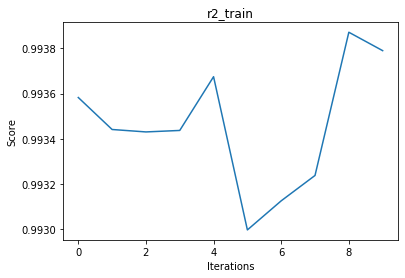

In [27]:
%time result, models = test(models, X, Y)
result

In [32]:
y_test.head(10)

1273    0.140351
2573    3.763158
51      0.066667
712     0.012987
1254    0.034483
3134    0.689655
1183    0.100000
2542    0.050000
896     0.750000
4188    0.344444
Name: SaleRateNew, dtype: float64

In [33]:
y_pred = models['OLS'].predict(X_test)
y_pred[:10]

array([ 0.40988011,  2.54073479, -0.31084114, -0.08165766,  0.32801483,
        0.7099669 ,  0.17583155,  0.12072664,  1.5068451 ,  0.54001803])

### Tunning

In [ ]:
ada_param = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

gbm_param = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['ls', 'lad', 'huber', 'quantile']
 }

models2 = {'Ada': GridSearchCV(AdaBoostRegressor(), 
                               param_grid=ada_param).fit(X, Y).best_estimator_,
          'GBM': GridSearchCV(GradientBoostingRegressor(), 
                               param_grid=gbm_param).fit(X, Y).best_estimator_}
%time test(models2, X, Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)



Running  Ada
012345678

In [ ]:
y_pred = models2['GBM'].predict(X_test)
print(y_pred[:10])
print(y_test.head(10))

In [ ]:
X_test.Inventory

In [ ]:
models2['Ada']

In [ ]:
models2['GBM']

### Number of days prediction (i.e Blowput period)

In [ ]:
#blowout
np.set_printoptions(formatter={'float_kind':float_formatter})
X_test['y_pred'] = y_pred
X_test['blowout_pred'] = pd.DataFrame({"Days" : X_test.Inventory / X_test['y_pred']})
X_test.head(10)
